26.25 19 true Sz = 0.28877879280705043 E0=2.6014512427825193e-8
 91.266177 seconds (846.14 M allocations: 55.338 GiB, 12.05% gc time, 2.46% compilation time)


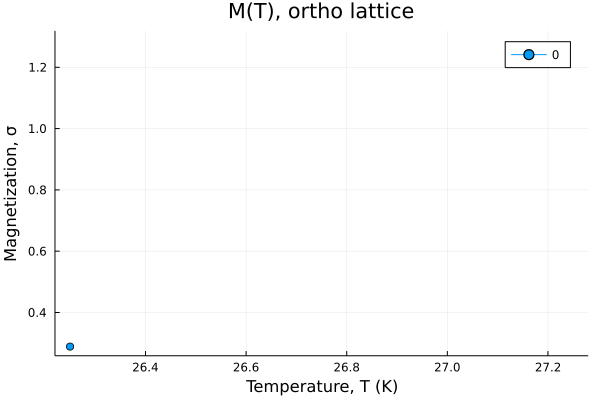

In [5]:
include("Input_Mod.jl")
include("Dipole_core.jl")
using .Input
using Printf
using Roots
using Cubature
using NLsolve
using Plots
using LinearAlgebra
using TOML
#using LoopVectorization
const μB=5.7883818060e-5 # eV/T
const kB=8.617333262e-5 # eV/K
const nkx=100; const nky=nkx
#
const S=3/2
const Niter=200
const δ=1e-4
const lattice_type = "ortho"


function Φ(n,Sz)
    if n==0
        return 0.0
    else
    Phi = 1
    for p=1:n
        Phi *= S*(S+1) - (n-p)*(n-p+1) - (2n-2p+1)*Sz - Sz^2
    end
    return Phi
    end
end
    
function correlator1(n,T,s) # <(S-)^n(S+)^n>, Eq.22
 #   x[1]=S
 #   x[2]=S^2
 #   x[3]=0
    y=zeros(3)
    N = nkx*nky
    Γ = 1 - (S*(S+1) - s[2]) / (2*S^2)
    β=1/kB/T
    sum1=0.0
    sum2=0.0
    sum3=0.0
    sum4=0.0
    for ikx = 1 : nkx, iky = 1 : nky
       kx = ikx - nkx/2 ; ky = iky - nky/2
       if kx==0&&ky==00 
           continue
        end
    Ek = ω([ikx/nkx,iky/nky],s[1],s[2])
    εk = ε([ikx/nkx,iky/nky],s[1])
    sum1 +=  n0(β,Ek)/(2*Ek)  * ( 2*E*Γ*s[1]*g2(n,y) + g1(n,s)*(Ek + εk + 2*D*Γ*s[1]) ) / N 
    sum2 += -n0(β,-Ek)/(2*Ek) * ( 2*E*Γ*s[1]*g2(n,y) - g1(n,s)*(Ek - εk - 2*D*Γ*s[1]) ) / N 
    sum3 += -n0(β,Ek)/(2*Ek)  * ( 2*E*Γ*s[1]*g1(n,s) - g2(n,y)*(Ek - εk - 2*D*Γ*s[1]) ) / N
    sum4 +=  n0(β,-Ek)/(2*Ek) * ( 2*E*Γ*s[1]*g1(n,s) + g2(n,y)*(Ek + εk + 2*D*Γ*s[1]) ) / N 
    end
        return sum1 + sum2   
end


function correlator(n,T,s,param) 
D = Input.D
E = Input.E
    N = nkx*nky
    Γ = 1 - (S*(S+1) - s[2]) / (2*S^2)
    β=1/kB/T
    sum = zeros(2)
    sum1=0.0;    sum2=0.0;    sum3=0.0;    sum4=0.0
    sum1a =0.0; sum2a=0.0; sum1b=0.0; sum2b=0.0; sum3a=0.0; sum4a=0.0; sum3b=0.0; sum4b=0.0
    for ikx = 1:nkx, iky = 1:nky
       shift = [-0.5, -0.5]
       k = [ ikx/nkx, iky/nky ] + shift
       Ek = ω(k,s[1],s[2])
       εk = ε(k,s[1])
        Ek1 = ω1(k,s[1],s[2])
        εk1 = ε1(k,s[1])
        Ek2 = ω2(k,s[1],s[2])
        εk2 = ε2(k,s[1])
        if (Ek < 1e-10)
            println("!!! Error, magnon spectrum gapless !!! E(k) < 1e-8 at k=",k)
        end
       x = [s[1],s[2],s[3]]
       y = [s[4],s[5],s[6]]
        sum1a +=  n0(β, Ek1)/(2*Ek1) * ( 2*E*Γ*s[1]*g2(n,y) + g1(n,x)*(Ek1 + εk1 + 2*D*Γ*s[1]) ) / N 
        sum2a += -n0(β,-Ek1)/(2*Ek1) * ( 2*E*Γ*s[1]*g2(n,y) - g1(n,x)*(Ek1 - εk1 - 2*D*Γ*s[1]) ) / N 
        sum1b +=  n0(β, Ek2)/(2*Ek2) * ( 2*E*Γ*s[1]*g2(n,y) + g1(n,x)*(Ek2 + εk2 + 2*D*Γ*s[1]) ) / N 
        sum2b += -n0(β,-Ek2)/(2*Ek2) * ( 2*E*Γ*s[1]*g2(n,y) - g1(n,x)*(Ek2 - εk2 - 2*D*Γ*s[1]) ) / N 
       sum[1] = sum1a + sum2a + sum1b + sum2b
        sum3a += -n0(β, Ek1)/(2*Ek1) * ( 2*E*Γ*s[1]*g1(n,x) - g2(n,y)*(Ek1 - εk1 - 2*D*Γ*s[1]) ) / N
        sum4a +=  n0(β,-Ek1)/(2*Ek1) * ( 2*E*Γ*s[1]*g1(n,x) + g2(n,y)*(Ek1 + εk1 + 2*D*Γ*s[1]) ) / N 
        sum3b += -n0(β, Ek2)/(2*Ek2) * ( 2*E*Γ*s[1]*g1(n,x) - g2(n,y)*(Ek2 - εk2 - 2*D*Γ*s[1]) ) / N
        sum4b +=  n0(β,-Ek2)/(2*Ek2) * ( 2*E*Γ*s[1]*g1(n,x) + g2(n,y)*(Ek2 + εk2 + 2*D*Γ*s[1]) ) / N 
       sum[2] = sum3a + sum4a + sum3b + sum4b
    end
    return sum
end



function correlator_cub(n,T,s)
    result = zeros(2)
D = Input.D
E = Input.E
    function integrand(n,T,s,k)
        sum = zeros(2)
        Γ = 1 - (S*(S+1) - s[2]) / (2*S^2)
        β=1/kB/T
        sum1a =0.0; sum2a=0.0; sum1b=0.0; sum2b=0.0; sum3a=0.0; sum4a=0.0; sum3b=0.0; sum4b=0.0
        Ek1 = ω1(k,s[1],s[2])
        εk1 = ε1(k,s[1])
        Ek2 = ω2(k,s[1],s[2])
        εk2 = ε2(k,s[1])
   #     if (Ek < 1e-8)
   #         error("!!! Error, magnon spectrum gapless !!! E(k) < 1e-8 at k=",k)
   #     end
        x = [s[1],s[2],s[3]]
        y = [s[4],s[5],s[6]]
        sum1a =  n0(β, Ek1) / (2*Ek1) * ( 2*E*Γ*s[1]*g2(n,y) + g1(n,x)*(Ek1 + εk1 + 2*D*Γ*s[1]) )
        sum2a = -n0(β,-Ek1) / (2*Ek1) * ( 2*E*Γ*s[1]*g2(n,y) - g1(n,x)*(Ek1 - εk1 - 2*D*Γ*s[1]) ) 
        sum1b =  n0(β, Ek2) / (2*Ek2) * ( 2*E*Γ*s[1]*g2(n,y) + g1(n,x)*(Ek2 + εk2 + 2*D*Γ*s[1]) )
        sum2b = -n0(β,-Ek2) / (2*Ek2) * ( 2*E*Γ*s[1]*g2(n,y) - g1(n,x)*(Ek2 - εk2 - 2*D*Γ*s[1]) ) 
        sum[1] = sum1a + sum2a  + sum1b + sum2b
        sum3a = -n0(β, Ek1) / (2*Ek1) * ( 2*E*Γ*s[1]*g1(n,x) - g2(n,y)*(Ek1 - εk1 - 2*D*Γ*s[1]) ) 
        sum4a =  n0(β,-Ek1) / (2*Ek1) * ( 2*E*Γ*s[1]*g1(n,x) + g2(n,y)*(Ek1 + εk1 + 2*D*Γ*s[1]) ) 
        sum3b = -n0(β, Ek2) / (2*Ek2) * ( 2*E*Γ*s[1]*g1(n,x) - g2(n,y)*(Ek2 - εk2 - 2*D*Γ*s[1]) ) 
        sum4b =  n0(β,-Ek2) / (2*Ek2) * ( 2*E*Γ*s[1]*g1(n,x) + g2(n,y)*(Ek2 + εk2 + 2*D*Γ*s[1]) ) 
        sum[2] = sum3a + sum4a  + sum3b + sum4b
        return sum
    end
    result[1] = hcubature(k -> integrand(n,T,s,k)[1], [-0.5,-0.5], [+0.5,+0.5], reltol=1e-6, abstol=1e-8, maxevals=0)[1]
    result[2] = hcubature(k -> integrand(n,T,s,k)[2], [-0.5,-0.5], [+0.5,+0.5], reltol=1e-6, abstol=1e-8, maxevals=0)[1]
    return result
end    


function ϕ(T,s)
    N = nkx*nky
    β=1/kB/T
    sum = 0.0
    for ikx = 1 : nkx, iky = 1 : nky
    kx = ikx - nkx/2 ; ky = iky - nky/2
    if kx==0&&ky==0
        continue
    end
    Ek = ω([ikx/nkx,iky/nky],s[1],s[2])
    sum += n0(β,Ek) / N  
    end
    return sum
end

function ϕ_cub(T,s)
    β=1/kB/T
    phi = hcubature(k -> n0(β,ω(k,s[1],s[2])), [-0.5,-0.5], [+0.5,+0.5], reltol=1e-6, maxevals=0)
    return phi
end


function ε(k,s)
J = Input.J
    if lattice_type == "square" || lattice_type == "triangular"
        Jk = γk(k[1],k[2]).*J
        J0 = γk(0,0).*J
        e_minus = s*(J0[1] - Jk[1])
    elseif lattice_type == "ortho"
        γ = γk(k[1],k[2])
        γ0 = γk(0,0)
        J11k = γ[1]*J[1] + γ[2]*J[2] + γ[4]*J[4]
        J12k = γ[3]*J[3]
        J110 = γ0[1]*J[1] + γ0[2]*J[2] + γ0[4]*J[4]
        J120 = γ0[3]*J[3]
  #      e_plus = 2*s* (J110 + J120 - J11k + J12k)
  #      e_minus = 2*s* (J110 + J120 - J11k - J12k)
    end
    return 0.0 #, e_minus]
end

function ε1(k,s)
  #  if lattice_type == "ortho"
J = Input.J
        γ = γk(k[1],k[2])
        γ0 = γk(0,0)
        J11k = γ[1]*J[1] + γ[2]*J[2] + γ[4]*J[4]
        J12k = γ[3]*J[3]
        J110 = γ0[1]*J[1] + γ0[2]*J[2] + γ0[4]*J[4]
        J120 = γ0[3]*J[3]
        e_minus = 2*s* (J110 + J120 - J11k - J12k)
  #  end
    return e_minus
end
function ε2(k,s)
 #   if lattice_type == "ortho"
J = Input.J
        γ = γk(k[1],k[2])
        γ0 = γk(0,0)
        J11k = γ[1]*J[1] + γ[2]*J[2] + γ[4]*J[4]
        J12k = γ[3]*J[3]
        J110 = γ0[1]*J[1] + γ0[2]*J[2] + γ0[4]*J[4]
        J120 = γ0[3]*J[3]
        e_plus = 2*s* (J110 + J120 - J11k + J12k)
 #   end
    return e_plus
end
#
#
function ω(k,s,ss)
D = Input.D
E = Input.E
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    εk = ε([k[1],k[2]],s)
    w = sqrt((εk + 2*D*Γ*s)^2 - (2*E*Γ*s)^2)
#    w = sqrt( (F1(k,s,ss))^2 - (F2(k,s,ss))^2)
    return w
end
function ω1(k,s,ss)
D = Input.D
E = Input.E
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    εk1 = ε1([k[1],k[2]],s)
    w1 = sqrt((εk1 + 2*D*Γ*s + 2*μB*0.00)^2 - (2*E*Γ*s)^2)
#    w1 = sqrt( (F1a(k,s,ss))^2 - (F2(k,s,ss))^2)
    return w1
end
function ω2(k,s,ss)
D = Input.D
E = Input.E
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    εk2 = ε2([k[1],k[2]],s)
    w2 = sqrt((εk2 + 2*D*Γ*s + 2*μB*0.00)^2 - (2*E*Γ*s)^2)
#    w2 = sqrt( (F1b(k,s,ss))^2 - (F2(k,s,ss))^2)
    return w2
end


function F1a(k,s,ss)
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    f1a = ε1(k,s) + s*pzz(k)*constant.Ω/2 + s*pxx(k)*constant.Ω/2 - s*pyy(k)*constant.Ω + 2*D*Γ*s
    return f1a
end
function F1b(k,s,ss)
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    f1b = ε2(k,s) + s*pzz(k)*constant.Ω/2 + s*pxx(k)*constant.Ω/2 - s*pyy(k)*constant.Ω + 2*D*Γ*s
    return f1b
end
function F1(k,s,ss)
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    f1 = ε(k,s) + s*pzz(k)*constant.Ω/2 + s*pxx(k)*constant.Ω/2 - s*pyy(k)*constant.Ω + 2*D*Γ*s
    return f1
end
function F2(k,s,ss)
    Γ = 1 - (S*(S+1) - ss) / (2*S^2)
    f2 = s*pzz(k)*constant.Ω/2 - s*pxx(k)*constant.Ω/2 + 2*E*Γ*s
    return f2
end


function γk(x,y)
    gamma = Float64[]
    if lattice_type == "square"
        γ1 = 2*( cos(2π*x) + cos(2π*y) )  
        γ2 = 4*( cos(2π*x)*cos(2π*y) )
        push!(gamma,γ1)
        push!(gamma,γ2)
    end
    if lattice_type == "triangular"
        γ1 = 2*(cos(2π*x) + 2*cos(2π*x/2)*cos(2π*√3y/2) )
        γ2 = 2*(cos(2π*√3y) + 2*cos(2π*3x/2)*cos(2π*√3y/2) )
        push!(gamma,γ1)
        push!(gamma,γ2)
    end
 #   if lattice_type == "honeycomb"
 #       gamma = Complex{Float64}[]
 #       γ1 = 1 + 2*cos(2π*x/2)*exp(im*2π√3ky/2)
 #       γ2 = 2*(cos(2π*x) + 2*cos(2π*x/2)*cos(2π*√3y/2) )
 #   end
     if lattice_type == "ortho"
         γ1 = 2*cos(2π*x)  
         γ2 = 2*cos(2π*y)  
         γ3 = 4*cos(2π*x/2)*cos(2π*y/2)
         γ4 = 4*( cos(2π*x)*cos(2π*y) )  
         push!(gamma,γ1)
         push!(gamma,γ2)
         push!(gamma,γ3)
         push!(gamma,γ4)
     end
    return gamma
end



function lhs1(n,s)
    x = [s[1],s[2],s[3]]
    y = [s[4],s[5],s[6]]
    if n==1 
        return 15/4 - x[1] - x[2]
    elseif n==2 
        return 6 - 13*x[1] + 4*x[3]
    elseif n==3
        return -9/4 + 3/2*x[1] + 9*x[2] - 6*x[3]
    else
        error("Error, n>3 not implemented")
    end
end
    

function lhs2(n,s)
    x = [s[1],s[2],s[3]]
    y = [s[4],s[5],s[6]]
    if n==1 
        return y[1]
    elseif n==2 
        return 15/4*y[1] + y[2] - y[3]
    elseif n==3
        return 27/2*y[1] - 6*y[3]
    else
        error("Error, n>3 not implemented")
    end
end


function g1(n,x)
    if n==1 
        return 2*x[1]
    elseif n==2
        return 15/2 + 13*x[1] - 6*x[2] - 4*x[3]
    elseif n==3
        return 45/2 - 42*x[1] - 18*x[2] + 24*x[3]
    else
        error("Error, n>3 not implemented")
    end
end

function g2(n,y)
    if n==1 
        return 0.0
    elseif n==2
        return -2*y[2]
    elseif n==3
        return -9*y[1] - 12*y[2] + 12*y[3]
    else
        error("Error, n>3 not implemented")
    end
end


function n0(β,ε)
    n0 = (exp(β*ε) - 1)^(-1)
end


function f!(F,s,T)
   F[1] = correlator_cub(1,T,s)[1] - 2*lhs1(1,s)
   F[2] = correlator_cub(2,T,s)[1] - 2*lhs1(2,s)
   F[3] = correlator_cub(3,T,s)[1] - 2*lhs1(3,s)    
   F[4] = correlator_cub(1,T,s)[2] - 2*lhs2(1,s)
   F[5] = correlator_cub(2,T,s)[2] - 2*lhs2(2,s)
   F[6] = correlator_cub(3,T,s)[2] - 2*lhs2(3,s)
end

function solver(T)
       solution = nlsolve((F,s) -> f!(F,s,T),[S,S^2,S^3,0.1,0.1,0.1],iterations=100,ftol=1e-6)
       println(T," ", solution.iterations, " ", converged(solution), " Sz = ", solution.zero[1], " E0=", ω([0,0],solution.zero[1],solution.zero[2]))
       return solution.zero
end


function plot_dispersion()

    println("gap= ",ω1([0.0,0.0],S,S^2))
     # for ky=-0.5:0.01:0.0
     #       println(0.0, "   ", ky, "   ", ω1([0.0,ky],S,S^2), "   ", ω2([0.0,ky],S,S^2))
     # end
     # for kx=0.0:0.01:0.5
     #       println(0.0, "   ",  kx, "   ", ω1([kx,0.0],S,S^2), "   ",ω2([kx,0.0],S,S^2))
     # end
     # for ky=0.5:0.01:1.0
     #       println(0.0, "   ", ky, "   ", ω1([0.5,ky-0.5],S,S^2), "   ", ω2([0.5,ky-0.5],S,S^2))
     # end 
    
     figure1 = plot(xlabel="k", ylabel = "ω(k)", title="Magnon dispersion, $lattice_type lattice")
     plot!(figure1, -0.5:0.05:0.0, ky -> ω1([0.0,ky],S,S^2), label=0, m=:circle,ls=:solid,color=:red)
     plot!(figure1,  0.0:0.05:0.5, kx -> ω1([kx,0.0],S,S^2), label=0, m=:circle,ls=:solid,color=:red)
     plot!(figure1,  0.5:0.05:1.0, ky -> ω1([0.5,ky-0.5],S,S^2), label=0, m=:circle,ls=:solid,color=:red)
     plot!(figure1, -0.5:0.05:0.0, ky -> ω2([0.0,ky],S,S^2), label=0, m=:circle,ls=:solid,color=:blue)
     plot!(figure1,  0.0:0.05:0.5, kx -> ω2([kx,0.0],S,S^2), label=0, m=:circle,ls=:solid,color=:blue)
     plot!(figure1,  0.5:0.05:1.0, ky -> ω2([0.5,ky-0.5],S,S^2), label=0, m=:circle,ls=:solid,color=:blue)
     figure1
    
end

function plot_magnetization(trange)
     figure = plot(xlabel="Temperature, T (K)", ylabel = "Magnetization, σ", title="M(T), $lattice_type lattice")
     plot!(figure, trange, T -> solver(T)[1], label=0, m=:circle,ls=:solid)
     figure
end
    

function main()
       
#plot_dispersion()
trange = 1 : 1 : 27
plot_magnetization(trange)
    
end

@time begin
    
main()

end


 










